# Discretization of the map for circular obstacles
This document will solve a discretization problem in which the obstacles are circular. To do this, we will first build a quantum circuit that checks if a point belongs to a set of points. Once this circuit is built, we can use Grover's algorithm to solve our problem.

To gain efficiency, we directly implement the two essential operators that include those detailed in the paper. The two operators, in addition to the oracle and the diffuser, are the `Euclidean distance (ED)`, the `sum to the square operator (AddSqr)`, and the `absolute value difference operator (AbsDiff)`.

The `Pennylane` library is not loaded by default in Google Colab. Therefore, it is possible to require its installation to execute the code.

In [19]:
!pip install pennylane > out

We import the libraries that we will need to solve the problem.

In [20]:
## Libraries
import numpy as np
import pennylane as qml
import matplotlib.pyplot as plt
## To compute the execution time
import time
%config InlineBackend.figure_format = 'retina'

The following functions will allow us to easily display the data of our problem.

In [21]:
# Pre-condition: matplotlib.pyplot (plt) must be imported
# Post-condition: The function 'draw_board' sets up the grid for plotting, and 'draw_points' plots the points from 'list_points' on the grid.


## Function to draw the grid
def draw_board():
    x_lim = [-1, 2**nCoordX]  # X-axis limits
    y_lim = [-1, 2**nCoordY]  # Y-axis limits

    # Setting the plot limits
    plt.xlim(x_lim[0], x_lim[1])
    plt.ylim(y_lim[0], y_lim[1])

    # Setting the labels for axes
    plt.xlabel('x coordinate')
    plt.ylabel('y coordinate')

    # Drawing grid lines
    nRows = 2**nCoordY
    for i in range(nRows):
        plt.plot([0, 2**nCoordX - 1], [i, i], color="black", linewidth=0.3)
        plt.plot([i, i], [0, 2**nCoordY - 1], color="black", linewidth=0.3)
    return

## Function to draw points on the grid
def draw_points(list_points):
    nPoints = len(list_points)
    for i in range(nPoints):
        plt.scatter(list_points[i][0], list_points[i][1], color="red")

In [22]:
# Pre-condition: numpy (np) and matplotlib.pyplot (plt) must be imported
# Post-condition: The Circle class allows creating and manipulating circle objects with methods for calculating area, drawing, and providing string representation.

## Class definition for Circle
class Circle:
    def __init__(self, center, radius):
        self.center = center  # Center of the circle as a tuple (x, y)
        self.radius = radius  # Radius of the circle

    def area(self):
        # Custom area calculation for specific radii
        if self.radius == 1:
            return 4
        if self.radius == 2:
            return 12
        # Generic area calculation for other radii
        return np.pi * self.radius**2

    def draw(self, color="blue"):
        # Drawing a circle on a plot
        nPoints = 1000
        angle = np.linspace(0, 2 * np.pi, nPoints)
        x = self.radius * np.cos(angle) + self.center[0]
        y = self.radius * np.sin(angle) + self.center[1]
        plt.plot(x, y, color=color)

    def __str__(self):
        return f"Center = ({self.center[0]},{self.center[1]}), Radio = {self.radius}"




Once we have the previous functions, we can show the problem we are going to solve.

The number of occupied squares is 32
The area occupied by the circles is 0.5


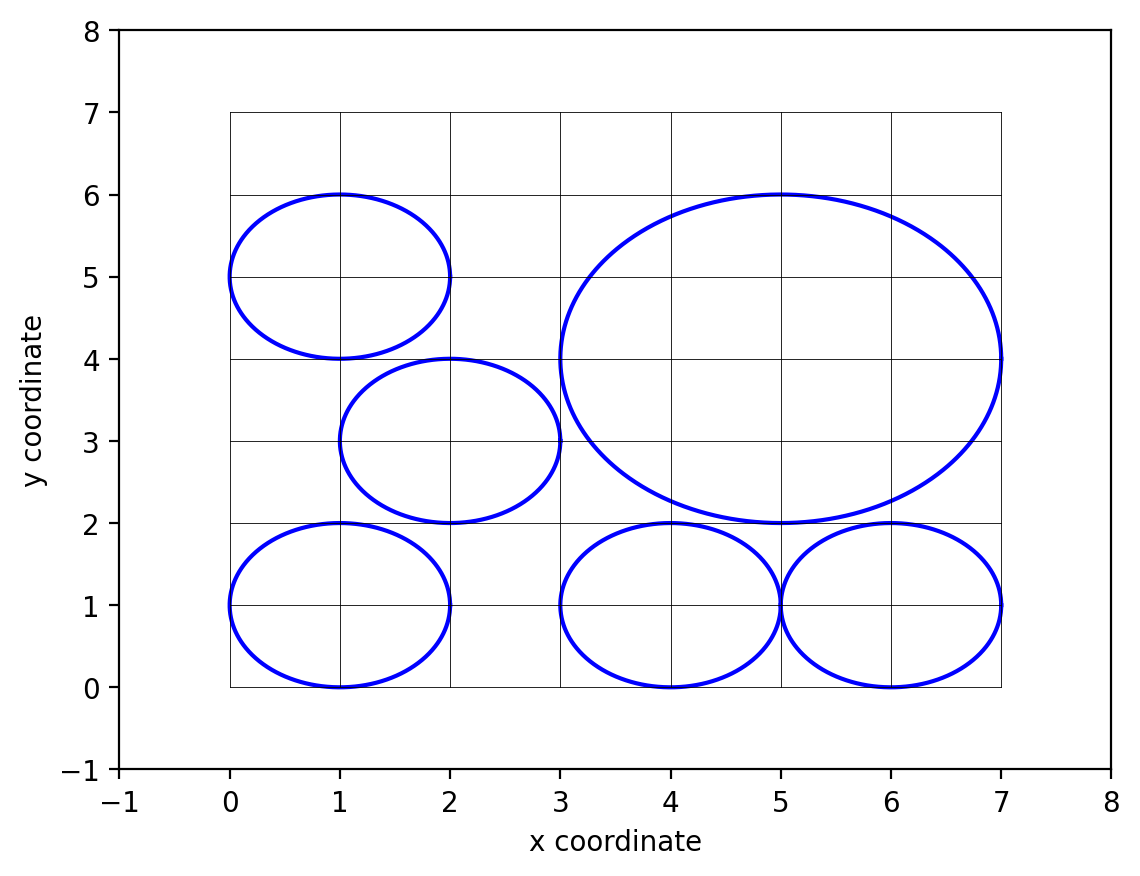

In [23]:
# Pre-condition: numpy (np), matplotlib.pyplot (plt), and Circle class must be defined
# Post-condition: The script calculates and visualizes the total area covered by a collection of circles within a defined grid.


## Setting the number of coordinates
nCoordX = 3
nCoordY = 3

## Creating the problem with a list of circles
list_circle = []

# Instantiating new Circle objects with different centers and radii
new_circle1 = Circle(np.array((1, 1)), 1)
new_circle2 = Circle(np.array((5, 4)), 2)
new_circle3 = Circle(np.array((1, 5)), 1)
new_circle4 = Circle(np.array((4, 1)), 1)
new_circle5 = Circle(np.array((6, 1)), 1)
new_circle6 = Circle(np.array((2, 3)), 1)

# Appending new circles to the list
list_circle.append(new_circle1)
list_circle.append(new_circle2)
list_circle.append(new_circle3)
list_circle.append(new_circle4)
list_circle.append(new_circle5)
list_circle.append(new_circle6)

## Drawing the problem
area_total = 0  # Initializing total area covered by circles
for circle in list_circle:
    area_total += circle.area()  # Summing up the area of each circle
    circle.draw()  # Drawing each circle

draw_board()  # Drawing the grid

# Calculating the proportion of area occupied by circles
por_area = area_total / ((2**nCoordX) * (2**nCoordY))
print("The number of occupied squares is", area_total)
print("The area occupied by the circles is", por_area)



Our objective will be to find points on the grid that do not belong to any of the circles.

In [24]:
# Pre-condition: numpy (np) must be imported
# Post-condition: Returns the integer value of a given binary array.

## Auxiliary function to convert a binary array to an integer
def binary_to_integer(vOutput):
    """
    Converts a binary array (vOutput) to its corresponding integer value.

    Args:
    vOutput (list or numpy array): A binary array representing a number.

    Returns:
    int: The integer value corresponding to the binary array.
    """
    # Creating an array of powers of 2 in reverse order
    vPows = 2 ** np.array(range(len(vOutput)))
    vPows = vPows[::-1]

    # Dot product of the binary array and the powers of 2 array gives the integer value
    return np.dot(vOutput, vPows)




### 2 Quantum circuits
The following set of functions implement quantum circuits that will allow us to perform the arithmetic operations necessary to solve our problem.

In [25]:
# Pre-condition: Pennylane (qml) must be imported
# Post-condition: Applies Hadamard gates and controlled rotations on specified qubits.

## Function to apply the Hadamard gate to a list of qubits
def apply_hadamard(wires_h):
    """
    Applies the Hadamard gate to each qubit in the list 'wires_h'.

    Args:
    wires_h (list): A list of qubit indices to which the Hadamard gate will be applied.
    """
    for i in wires_h:
        qml.Hadamard(wires=i)

## Function to perform a controlled rotation
def sum_k(k, wires):
    """
    Performs a controlled rotation on the qubits in 'wires' based on the value of 'k'.

    Args:
    k (float): The rotation parameter.
    wires (list): A list of qubit indices on which the rotation will be applied.
    """
    for j in range(len(wires)):
        qml.RZ(k * np.pi / (2**j), wires=wires[j])


The following function implements the operation $h_k(x) = |x-k|$

In [26]:
# Pre-condition: Pennylane (qml) must be imported, sum_k function defined
# Post-condition: Computes the absolute difference and stores it in the specified result qubits.

## Function to compute the absolute difference
def AbsDiff(k, wires_x, wires_aux, wires_res_ori):
    """
    Computes the absolute difference between a quantum register value and a constant 'k'.

    Args:
    k (int): A constant value to subtract from the quantum register.
    wires_x (list): Quantum register containing the value to be subtracted from 'k'.
    wires_aux (list): Ancillary qubits for the computation.
    wires_res_ori (list): Original result qubits, used for storing the computed absolute difference.
    """
    # Check sufficient qubits for results and auxiliary operations
    if len(wires_res_ori) < len(wires_x):
        print("The number of result qubits must be more than the value qubits")
        return
    if len(wires_aux) < 2:
        print("The number of ancillary qubits must be more than 1")
        return

    # Initialize working qubits
    init_qubit = len(wires_res_ori) - len(wires_x)
    wires_res = wires_res_ori[init_qubit:]
    n = len(wires_x)

    # Duplicate value from wires_x to wires_res
    for i in range(n):
        qml.CNOT(wires=[wires_x[i], wires_res[i]])

    # Check if value in wires_x is less than constant 'k'
    new_wires_x = [wires_aux[0]] + wires_x
    qml.QFT(new_wires_x)
    sum_k(-k, new_wires_x)
    qml.adjoint(qml.QFT)(new_wires_x)

    # Compute 2^n - value in wires_x
    for i in range(n):
        qml.CNOT(wires=[wires_aux[0], wires_res[i]])
    wires_res_extra = [wires_aux[1]] + wires_res

    # Perform summation operations
    qml.QFT(wires=wires_res_extra)
    qml.ctrl(sum_k, control=wires_aux[0])(1+k-2**n, wires_res_extra)
    qml.PauliX(wires=wires_aux[0])
    qml.ctrl(sum_k, control=wires_aux[0])(-k, wires_res_extra)
    qml.PauliX(wires=wires_aux[0])
    qml.adjoint(qml.QFT)(wires=wires_res_extra)

    # Restore original state
    qml.QFT(new_wires_x)
    sum_k(k, new_wires_x)
    qml.adjoint(qml.QFT)(new_wires_x)



We now create a device with which we will verify that the `AbsDiff` function that we have just developed works correctly.

In [27]:
# Pre-condition: Pennylane (qml) must be imported, AbsDiff function defined
# Post-condition: Creates and returns a quantum node (qnode) that computes |x - k| and samples the quantum state.
n = 5
wires_x = list(range(n))
wires_aux = list(range(wires_x[-1]+1, wires_x[-1]+3))
wires_res = list(range(wires_aux[-1]+1, wires_aux[-1]+1+n))
nTotalWires = wires_res[-1] + 1
## Creating the quantum circuit

dev = qml.device('default.qubit.tf', wires = nTotalWires, shots = 1)
@qml.qnode(dev)
def circuit(value_x, value_k, wires_x, wires_aux, wires_res):
    """
    Defines a quantum circuit to compute the absolute difference between a quantum register and a constant.

    Args:
    value_x (int): Binary representation of the input value.
    value_k (int): Constant value 'k' for the subtraction.
    wires_x (list): Quantum register for the input value.
    wires_aux (list): Ancillary qubits for computation.
    wires_res (list): Quantum register for storing the result.

    Returns:
    sample: The quantum state sample after applying the circuit.
    """
    # Basis embedding for the input value
    qml.BasisEmbedding(value_x, wires=wires_x)

    # Applying the AbsDiff function to compute |x - k|
    AbsDiff(value_k, wires_x, wires_aux, wires_res)

    # Returning the sample of the quantum state
    return qml.sample()


In [28]:
# Pre-condition: 'binary_to_integer' function, 'circuit' function, and necessary PennyLane (qml) imports must be defined
# Post-condition: Displays the binary integer value of x and the computed absolute difference.


# Example use of the quantum circuit
value_x = 21
value_k = 25

# Executing the quantum circuit to compute the absolute difference
sol = circuit(value_x, value_k, wires_x, wires_aux, wires_res)
sol = sol.numpy()  # Converting the solution to a NumPy array

# Extracting and displaying the results
x_value = binary_to_integer(sol[wires_x])
abs_diff_value = binary_to_integer(sol[wires_res])

print(f"The value of x is {x_value}")
print(f"The value of |{value_x} - {value_k}| = {abs_diff_value}")

The value of x is 21
The value of |21 - 25| = 4


The quantum circuits in the back cell implement the following functions.
 + Inplace Quantum Square Adder Operator: $AddSqr_{in}(x, a) = (x, a + x^2)$
 + Quantum Euclidean Distance: $ED{(p_1,p_2)}(x, y, a) = (x, y, (x-p_1)^2 + (y-p_2)^2)$

In [29]:
# This function computes the square of a binary number represented by qubits
# Pre-condition: 'sum_k' function and necessary PennyLane (qml) imports must be defined
# Post-condition: Computes the square of a binary number and stores the result in 'wires_res'

def AddSqr(wires_x, wires_res):
    # Check if the number of result wires is sufficient (2n for an n-bit number)
    if len(wires_res) < 2*len(wires_x):
        print("Error computing the square. The result wires must be 2n")
        return

    n = len(wires_x)

    # Iterate over all pairs of qubits in wires_x
    for i in range(n-1):
        for j in range(i+1, n):
            value = 2*n - i - j - 1
            # Apply a controlled sum_k gate for each pair of qubits
            qml.ctrl(sum_k, control=[wires_x[i], wires_x[j]])(2**(value), wires_res)

    # Iterate over all qubits in wires_x
    for i in range(n):
        value = n - i - 1
        # Apply a controlled sum_k gate for each qubit
        qml.ctrl(sum_k, control=[wires_x[i]])(2**(2*value), wires_res)

In [30]:
# This function calculates the distance (Euclidean Distance (ED)) between a point and a point represented by qubits
# Pre-condition: 'AbsDiff', 'AddSqr', and necessary PennyLane (qml) imports must be defined
# Post-condition: Computes the squared distance between a point and a point represented by qubits in 'wires_x' and 'wires_y', and stores the result in 'wires_res'

def ED(point, wires_x, wires_y, wires_aux, wires_res):
    nQubits_x = len(wires_x)
    nQubits_y = len(wires_y)

    # Check if there are enough wires in the result and auxiliary wires
    if len(wires_res) < (2 * len(wires_x) + 1):
        print("Error computing distance: Not enough wires_res")
        return
    if len(wires_aux) < (len(wires_x) + 2):
        print("Error computing distance: not enough wires_aux")
        return

    # Set the correct wires for the absolute value calculation
    wires_res_abs = wires_aux[2:]
    wires_aux_abs = wires_aux[:2]

    # Compute |x - c_1| and store the result in wires_res_abs
    AbsDiff(point[0], wires_x, wires_aux_abs, wires_res_abs)

    # Now, square |x - c_1| and store it in wires_res
    qml.QFT(wires=wires_res)
    AddSqr(wires_res_abs, wires_res)
    qml.adjoint(qml.QFT)(wires=wires_res)

    # Restore wires_res_abs to the initial state
    qml.adjoint(AbsDiff)(point[0], wires_x, wires_aux_abs, wires_res_abs)

    # Apply the same procedure for wires_y
    AbsDiff(point[1], wires_y, wires_aux_abs, wires_res_abs)

    qml.QFT(wires=wires_res)
    AddSqr(wires_res_abs, wires_res)
    qml.adjoint(qml.QFT)(wires=wires_res)

    # Restore wires_res_abs to the initial state
    qml.adjoint(AbsDiff)(point[1], wires_y, wires_aux_abs, wires_res_abs)

    return


### 3 Grover's algorithm
Once we have built all the previous functions we can build Grover's algorithm that will allow us to find points on the grid optimally.

In [31]:
# The DifusorOperator function implements the diffuser phase of Grover's algorithm
# Pre-conditions:
# - 'apply_hadamard' function must be defined
# - Necessary PennyLane (qml) imports must be in place
# - Appropriate number of quantum wires must be allocated for 'wires_x', 'wires_y', 'wires_aux', and 'wire_extra_qubit'

# Post-condition:
# - Implements the diffuser phase of Grover's algorithm, which is used to amplify the probability amplitudes of the desired states
# - Operates on the quantum wires 'wires_x', 'wires_y', and an additional qubit 'wire_extra_qubit' using an auxiliary qubit in 'wires_aux'

def DifusorOperator(wires_x, wires_y, wires_aux, wire_extra_qubit):
    # Apply Pauli-X and Hadamard gates to the auxiliary wire
    qml.PauliX(wires=wires_aux[0])
    qml.Hadamard(wires=wires_aux[0])

    # Apply Hadamard gates to all qubits involved in the diffuser phase
    apply_hadamard(wires_x)
    apply_hadamard(wires_y)
    apply_hadamard(wire_extra_qubit)

    # Create a string of control values and apply a multi-controlled X gate
    wires_join = wires_x + wires_y + [wire_extra_qubit[0]]
    vStringCombo = ''.join(str(0) for j in range(len(wires_join)))
    qml.MultiControlledX(control_wires=wires_join, wires=wires_aux[0], control_values=vStringCombo)

    # Apply a unitary operation to negate the phase
    qml.QubitUnitary(-np.eye(2), wires=0)

    # Apply Hadamard gates again to revert to the original basis
    apply_hadamard(wires_x)
    apply_hadamard(wires_y)
    apply_hadamard(wire_extra_qubit)

    # Restore the state of the auxiliary qubit
    qml.Hadamard(wires=wires_aux[0])
    qml.PauliX(wires=wires_aux[0])
    return


In [32]:
# The oracle_circle function creates a quantum oracle for a single circular obstacle
# Pre-conditions:
# - 'distance', 'sum_k', and necessary PennyLane (qml) imports must be defined
# - Appropriate number of quantum wires must be allocated for 'wires_x', 'wires_y', 'wires_aux', and 'wires_extra_qubit'

# Post-condition for oracle_circle:
# - Creates a quantum oracle for a single circular obstacle, calculating the distance from the circle's center and comparing it with the circle's radius
# - Modifies the state of 'wires_extra_qubit' based on the inclusion of the point within the circle

# Post-condition for oracle_list_circle:
# - Creates a quantum oracle for a list of circular obstacles, applying 'oracle_circle' for each circle in the list
# - Modifies the state of 'wires_extra_qubit' based on the inclusion of the point within any of the circles

def oracle_circle(circle, wires_x, wires_y, wires_aux, wires_extra_qubit):
    # Retrieve necessary values and check for sufficient ancillary qubits
    n1 = len(wires_x)
    n2 = len(wires_y)
    n = max(n1, n2)
    nWiresSol = 2 * n + 1
    if len(wires_aux) < nWiresSol + n + 3:
        print("Not enough ancillary qubits to build the oracle")

    # Set up the necessary wires for the calculation
    wires_distance = wires_aux[:nWiresSol]
    wires_aux_distance = wires_aux[nWiresSol:(nWiresSol + n + 2)]
    wires_compare_distance = [wires_aux[nWiresSol + n + 2]] + wires_distance

    # Build the circuit to compute the distance and compare it with the radius
    ED(circle.center, wires_x, wires_y, wires_aux_distance, wires_distance)
    qml.QFT(wires=wires_compare_distance)
    sum_k(-(circle.radius**2 + 1), wires_compare_distance)
    qml.adjoint(qml.QFT)(wires=wires_compare_distance)

    # Apply the oracle operation
    if 1 == 0:
        U = -np.eye(2)
        qml.ctrl(qml.QubitUnitary(U, wires=wires_x[0]), control=[wires_compare_distance[0], wires_extra_qubit[0]], control_values=['1', '1'])
    else:
        qml.Toffoli(wires=[wires_compare_distance[0], wires_extra_qubit[0], wires_extra_qubit[1]])

    # Restore the state of the wires to their original configuration
    qml.QFT(wires=wires_compare_distance)
    sum_k(circle.radius**2 + 1, wires_compare_distance)
    qml.adjoint(qml.QFT)(wires=wires_compare_distance)
    qml.adjoint(ED)(circle.center, wires_x, wires_y, wires_aux_distance, wires_distance)

# The oracle_list_circle function creates a quantum oracle for a list of circular obstacles
def oracle_list_circle(list_circle, wires_x, wires_y, wires_aux, wires_extra_qubit):
    qml.PauliX(wires=wires_extra_qubit[1])
    qml.Hadamard(wires_extra_qubit[1])
    for circle in list_circle:
        oracle_circle(circle, wires_x, wires_y, wires_aux, wires_extra_qubit)

    qml.CNOT([wires_extra_qubit[0], wires_extra_qubit[1]])
    qml.Hadamard(wires_extra_qubit[1])
    qml.PauliX(wires=wires_extra_qubit[1])


The following device allows you to verify that all of the above is correct.

In [33]:
## Create the quantum circuit
# Define the number of quantum bits (qubits) for coordinates and auxiliary purposes
# Pre-conditions:
# - 'apply_hadamard', 'oracle_list_circle', 'DifusorOperator', and necessary PennyLane (qml) imports must be defined
# - Appropriate number of quantum wires must be allocated for 'wires_x', 'wires_y', 'wires_aux', and 'wires_extra_qubit'

# Post-condition:
# - The function 'circuit' creates a quantum circuit for Grover's algorithm
# - The circuit is designed to find points outside the defined circular regions using the provided list of circles
# - The results are stored in 'list_points'

n = 3
nWiresAux = 3 * n + 4
wires_x = list(range(n)) # Wires for the x-coordinate
wires_y = list(range(wires_x[-1] + 1, wires_x[-1] + 1 + n)) # Wires for the y-coordinate
wires_aux = list(range(wires_y[-1] + 1, wires_y[-1] + 1 + nWiresAux)) # Auxiliary wires
wires_extra_qubit = [wires_aux[-1] + 1, wires_aux[-1] + 2] # Extra qubits for the oracle and diffuser
nTotalWires = wires_extra_qubit[-1] + 1 # Total number of qubits in the circuit

# Initialize the quantum device with TensorFlow backend
dev = qml.device('default.qubit.tf', wires=nTotalWires, shots=1)

@qml.qnode(dev)
def circuit(list_circle, wires_x, wires_y, wires_aux, wires_extra_qubit):
    ## Set the state to superposition using Hadamard gates
    # Uncomment to set specific values for x and y
    # qml.BasisEmbedding(5, wires_x)
    # qml.BasisEmbedding(7, wires_y)
    # qml.PauliX(wires_extra_qubit[0])

    # Apply Hadamard gates to the coordinate wires and the extra qubit
    apply_hadamard(wires_x)
    apply_hadamard(wires_y)
    qml.Hadamard(wires=wires_extra_qubit[0])

    ## Apply Grover's iterator
    # Oracle for a list of circles
    oracle_list_circle(list_circle, wires_x, wires_y, wires_aux, wires_extra_qubit)
    # Diffuser operator
    DifusorOperator(wires_x, wires_y, wires_aux, [wires_extra_qubit[0]])
    return qml.sample()

# Initialize the list of points to store the results
list_points = []


In [34]:
## Conducting a test run
# Record the start time for performance measurement
# Pre-conditions:
# - The 'circuit' function and necessary PennyLane (qml) imports must be defined
# - 'binary_to_integer' function should be available to convert binary results to integers
# - 'list_circle', 'wires_x', 'wires_y', 'wires_aux', and 'wires_extra_qubit' must be correctly initialized and passed to the 'circuit' function

# Post-condition:
# - Executes the quantum circuit for the given list of circles and quantum wires
# - Converts the quantum measurement outcome to a point in 2D space
# - Appends the result to 'list_points' and prints the execution time

start_time = time.time()

# Execute the quantum circuit and convert the result to a numpy array
solution = circuit(list_circle, wires_x, wires_y, wires_aux, wires_extra_qubit)
solution = solution.numpy()

# Convert the binary output to integers for x and y coordinates
point_solution = np.array((binary_to_integer(solution[wires_x]), binary_to_integer(solution[wires_y])))
print("The point is (", point_solution[0], ",", point_solution[1], ")")

# Add the obtained point to the list of points
list_points.append(point_solution)

# Calculate and print the total execution time
end_time = time.time()
total_time = end_time - start_time
print("Execution time was:", total_time, "seconds")


The point is ( 7 , 6 )
Execution time was: 31.94272208213806 seconds


The point is ( 0 , 7 )
The point is ( 7 , 3 )
The point is ( 3 , 0 )
The point is ( 3 , 7 )
The point is ( 4 , 6 )
The point is ( 2 , 0 )
The point is ( 3 , 6 )
The point is ( 3 , 0 )
The point is ( 6 , 7 )
The point is ( 7 , 6 )
Total execution time was: 273.8678619861603 seconds


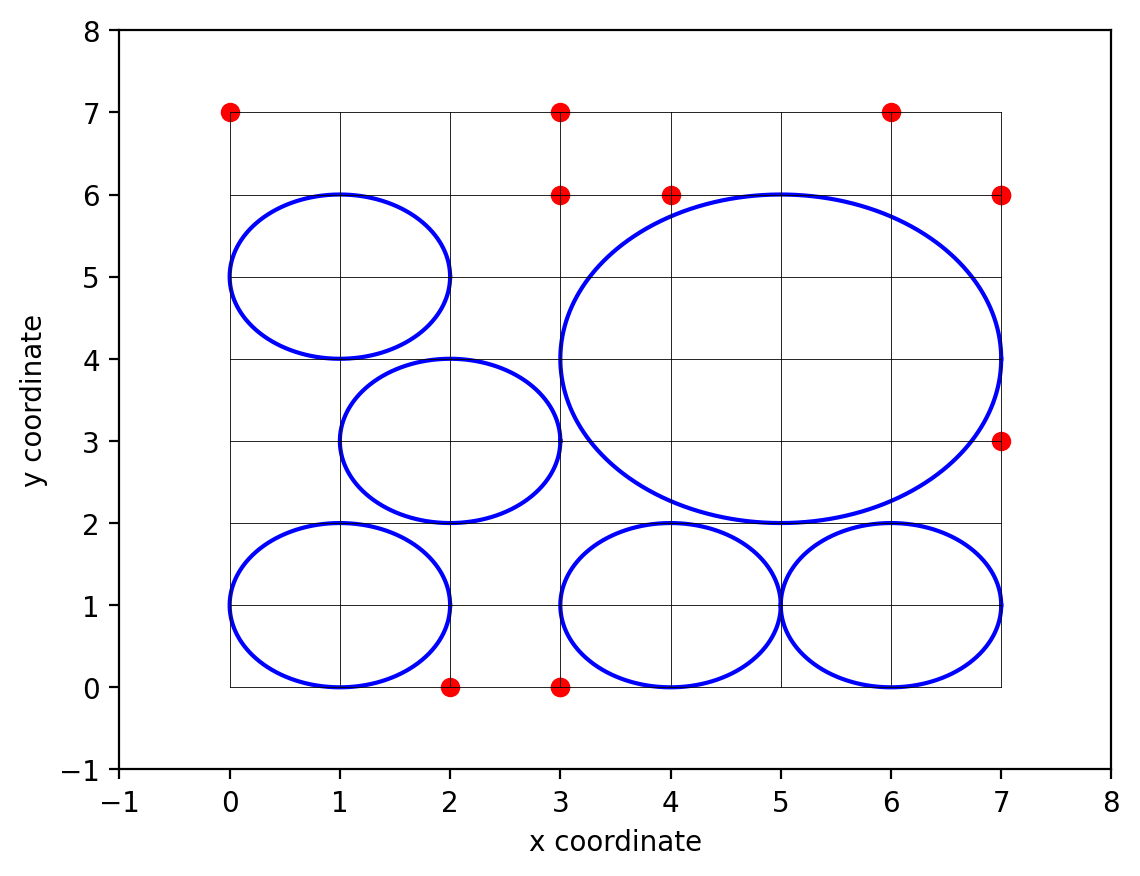

In [35]:
# Set the number of points to generate
nPoints = 10

# Record the start time for performance measurement
start_time = time.time()

# Loop to generate 'nPoints' points
for i in range(nPoints):
    # Execute the quantum circuit
    solution = circuit(list_circle, wires_x, wires_y, wires_aux, wires_extra_qubit)
    # Convert the solution to a numpy array
    solution = solution.numpy()
    # Convert binary output to integer coordinates
    point_solution = np.array((binary_to_integer(solution[wires_x]), binary_to_integer(solution[wires_y])))
    print("The point is (", point_solution[0], ",", point_solution[1], ")")
    # Add the point to the list of points
    list_points.append(point_solution)

# Calculate and print the total time taken for the entire operation
end_time = time.time()
total_time = end_time - start_time
print("Total execution time was:", total_time, "seconds")

# Draw the problem scenario
# Iterate over each circle in the list and draw them
for circle in list_circle:
    circle.draw()

# Draw the grid and the points
draw_board()
draw_points(list_points)

# Pre-conditions:
# - The 'circuit' function, 'draw_board', and 'draw_points' must be defined
# - Necessary PennyLane (qml) imports and other required functions should be available
# - 'list_circle', 'wires_x', 'wires_y', 'wires_aux', and 'wires_extra_qubit' should be correctly initialized and passed to the 'circuit' function
# - 'binary_to_integer' function is needed to convert binary results to integers

# Post-condition:
# - Executes the quantum circuit 'nPoints' times to generate points
# - Each point is appended to 'list_points' and printed
# - The total execution time for generating all points is calculated and printed
# - The circles and generated points are visualized on the board


Cite this work: